# Library import and data preprocessing

**Importing the libraries**

In [4]:
import torch
print(torch.cuda.is_available())

True


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

**Data Transformation**

Defines a set of transformations to be applied to images for data augmentation and normalization during the training, validation, and testing phases.

In [6]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Importing the annotated and labeled dataset

In [ ]:
# Define the data directory
data_dir = '/home/pushan/Desktop/ML/ML_PROJECT/4628934/roi_extracted'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
#image_datasets

**Dataloader**

for loading and batching image datasets and retrieves the dataset sizes and class names.

In [5]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 6452, 'val': 806, 'test': 809}


['cocci', 'healthy', 'ncd', 'salmo']

# Classification Model

**Resnet50**

The pretrained model used for prediction by freezing all the layer except the final layer(classification layer) allowing model to update weight of the classification layer according to the given dataset.


In [6]:
# Load the pre-trained VGG-19 model
model = models.vgg19(pretrained=True)

# Freeze all layers except the fully connected (classifier) layers
for name, param in model.named_parameters():
    if "classifier" in name:  # Enable training for classifier layers
        param.requires_grad = True
    else:  # Freeze all other layers
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model is successfully loaded and moved to {device}")


/home/pushan/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pushan/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model is successfully loaded and moved to cuda:0


**Training the model**

Using transfer learning on resnet50 model to use it for classification of poultry disease given the fecal images



In [7]:
from tqdm import tqdm
import torch

# Early stopping parameters
patience = 5
best_loss = float('inf')
early_stop_counter = 0

# Lists to store metrics
val_losses = []
val_accuracies = []
train_losses = []
train_accuracies = []

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 20)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Wrap the dataloader with tqdm
        dataloader_tqdm = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase')

        for inputs, labels in dataloader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics in the respective lists
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        elif phase == 'val':
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

            # Early stopping logic
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                early_stop_counter = 0  # Reset counter if validation loss improves
            else:
                early_stop_counter += 1

    # Check if early stopping is triggered
    if early_stop_counter >= patience:
        print(f'Early stopping triggered at epoch {epoch + 1}.')
        break

print("Training complete!")

# Display stored metrics
print("Train Losses:", train_losses)
print("Train Accuracies:", train_accuracies)
print("Validation Losses:", val_losses)
print("Validation Accuracies:", val_accuracies)

Epoch 1/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [05:32<00:00,  4.84it/s]


Train Loss: 0.6607 Acc: 0.7967


Val Phase: 100%|██████████| 202/202 [00:42<00:00,  4.72it/s]


Val Loss: 0.4303 Acc: 0.8573
Epoch 2/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [05:58<00:00,  4.49it/s]


Train Loss: 0.4224 Acc: 0.8565


Val Phase: 100%|██████████| 202/202 [00:48<00:00,  4.16it/s]


Val Loss: 0.2915 Acc: 0.8995
Epoch 3/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [06:47<00:00,  3.96it/s]


Train Loss: 0.3874 Acc: 0.8645


Val Phase: 100%|██████████| 202/202 [00:52<00:00,  3.82it/s]


Val Loss: 0.2569 Acc: 0.9094
Epoch 4/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [06:53<00:00,  3.90it/s]


Train Loss: 0.3594 Acc: 0.8762


Val Phase: 100%|██████████| 202/202 [00:51<00:00,  3.89it/s]


Val Loss: 0.2265 Acc: 0.9218
Epoch 5/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [06:46<00:00,  3.97it/s]


Train Loss: 0.3319 Acc: 0.8847


Val Phase: 100%|██████████| 202/202 [00:48<00:00,  4.17it/s]


Val Loss: 0.3181 Acc: 0.8921
Epoch 6/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [06:36<00:00,  4.07it/s]


Train Loss: 0.3192 Acc: 0.8904


Val Phase: 100%|██████████| 202/202 [00:50<00:00,  3.98it/s]


Val Loss: 0.2080 Acc: 0.9330
Epoch 7/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [06:27<00:00,  4.16it/s]


Train Loss: 0.2909 Acc: 0.8971


Val Phase: 100%|██████████| 202/202 [00:49<00:00,  4.04it/s]


Val Loss: 0.2308 Acc: 0.9256
Epoch 8/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [06:26<00:00,  4.17it/s]


Train Loss: 0.2981 Acc: 0.8965


Val Phase: 100%|██████████| 202/202 [00:48<00:00,  4.12it/s]


Val Loss: 0.2115 Acc: 0.9194
Epoch 9/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [06:12<00:00,  4.33it/s]


Train Loss: 0.2702 Acc: 0.9003


Val Phase: 100%|██████████| 202/202 [00:29<00:00,  6.92it/s]


Val Loss: 0.2858 Acc: 0.9057
Epoch 10/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:49<00:00,  7.03it/s]


Train Loss: 0.2773 Acc: 0.9011


Val Phase: 100%|██████████| 202/202 [00:28<00:00,  7.05it/s]


Val Loss: 0.2381 Acc: 0.9181
Epoch 11/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:52<00:00,  6.94it/s]


Train Loss: 0.2654 Acc: 0.9062


Val Phase: 100%|██████████| 202/202 [00:28<00:00,  7.03it/s]

Val Loss: 0.2521 Acc: 0.9119
Early stopping triggered at epoch 11.
Training complete!
Train Losses: [0.6606537445570574, 0.4223541900737104, 0.387366571864505, 0.3594328806671579, 0.33191450237929965, 0.319232358293477, 0.2909100551265439, 0.29812134040660065, 0.2701663765366667, 0.2773199297401638, 0.2653948769555178]
Train Accuracies: [0.7966522008679479, 0.8564786112833229, 0.8645381277123372, 0.8761624302541847, 0.8846869187848728, 0.8904215747055176, 0.8970861748295101, 0.8964662120272783, 0.9003409795412275, 0.9011159330440173, 0.9062306261624302]
Validation Losses: [0.43028562153673333, 0.2915187929059114, 0.25689674413470537, 0.22652360641217045, 0.3180565226802829, 0.2080212473642081, 0.23076902907774485, 0.21153220040614812, 0.2858118932310472, 0.23807811532236756, 0.25210866189906495]
Validation Accuracies: [0.8573200992555832, 0.8995037220843672, 0.9094292803970223, 0.9218362282878412, 0.892059553349876, 0.9330024813895782, 0.9255583126550868, 0.9193548387096774, 0.90570719

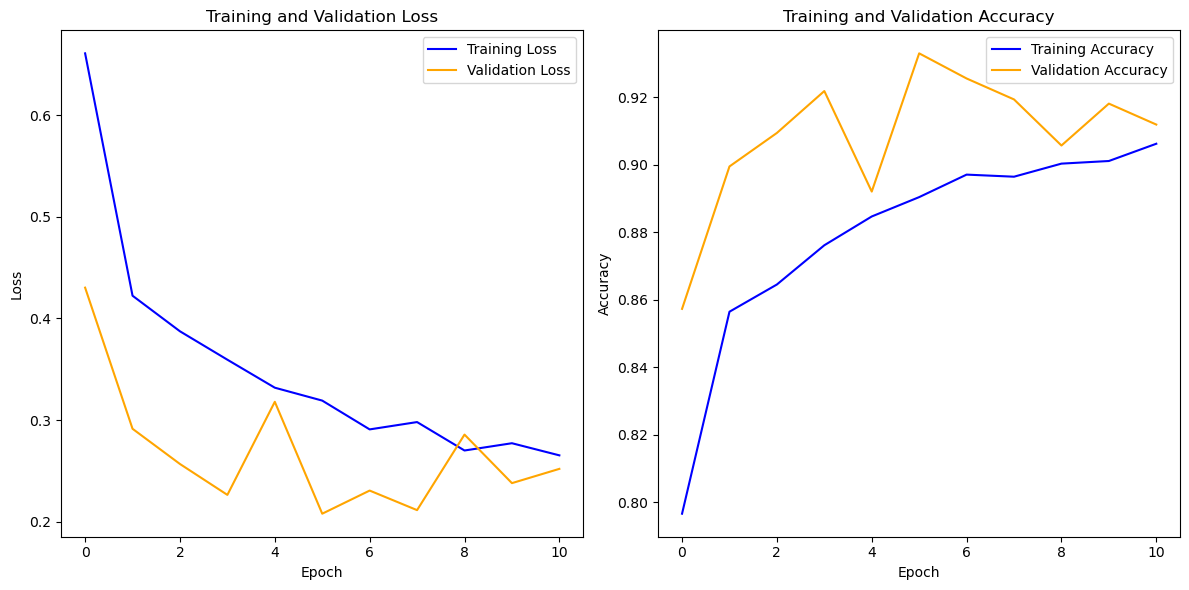

In [9]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(12, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

**Model Evaluation**

Evaluating the model's performance on the test dataset to achieve the test accuracy > 92%

In [8]:
!pip install scikit-learn

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Initialize test accuracy and loss
test_loss = 0.0
correct_predictions = 0

# Initialize lists to store predictions and true labels for the confusion matrix
all_preds = []
all_labels = []

# Turn off gradients for validation (saves memory and computations)
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        test_loss += loss.item() * inputs.size(0)

        # Collect all predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate average loss and accuracy
test_loss = test_loss / dataset_sizes['test']
test_acc = correct_predictions.double() / dataset_sizes['test']

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.2543, Test Accuracy: 0.9011


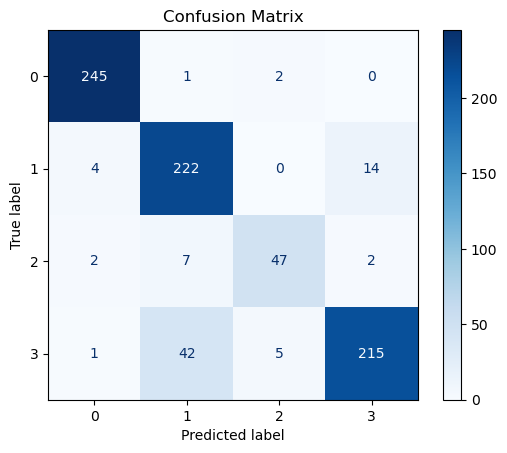

In [11]:
# Compute and display the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [12]:
torch.save(model.state_dict(), '/home/pushan/Desktop/ML/ML_PROJECT/4628934/final_files/vggnet.pth')

#An utility function
This is an utility function to have prediction using the trained model and a given image using *image_path* *italicised text*

In [2]:
import torch
from torchvision import models
import torch.nn as nn

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved VGG-16 model
model = models.vgg19(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('/home/pushan/Desktop/ML/ML_PROJECT/4628934/final_files/vggnet.pth', map_location=device))
model = model.to(device)  # Move the model to GPU or CPU
model.eval()

# Create a new VGG-16 model with the correct final layer
new_model = models.vgg16(pretrained=True)
new_model.classifier[6] = nn.Linear(new_model.classifier[6].in_features, 1000)  # Ensure the output layer has 1000 classes
new_model = new_model.to(device)  # Move the new model to GPU or CPU

# Copy the weights and biases from the loaded model to the new model
new_model.classifier[6].weight.data = model.classifier[6].weight.data.to(device)
new_model.classifier[6].bias.data = model.classifier[6].bias.data.to(device)


/home/pushan/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pushan/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_159881/250809547.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/

**Preprocessing**

the image is being preprocessed similary as of train data before being fed up for the prediction

In [7]:
from PIL import Image

image_path = '/home/pushan/Desktop/ML/ML_PROJECT/4628934/roi_extracted/val/salmo/salmo.2101.jpg'  # Replace with the path to your image
image = Image.open(image_path)

# Use the 'test' transform from data_transforms
preprocess = data_transforms['test']
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

# Ensure the tensor is moved to the appropriate device if necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)

# Print the input_batch shape to verify
print("Input batch shape:", input_batch.shape)


Input batch shape: torch.Size([1, 3, 224, 224])


In [8]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['cocci', 'healthy', 'ncd', 'salmo']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: salmo


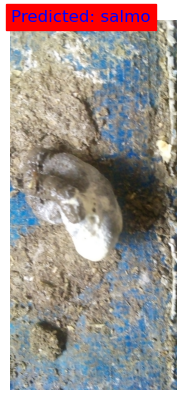

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='blue', backgroundcolor='red')
plt.show()